In [ ]:
pip install qiskit==2.1

In [ ]:
pip install qiskit_aer==0.17

In [ ]:
pip install qiskit_ibm_runtime==0.40

In [ ]:
pip install numpy==2.2

In [ ]:
pip install pylatexenc==2.10

In [ ]:
pip install matplotlib==3.10

# Chapter 10. Coding with Many Qubits in Qiskit

## 10.1. Working with many qubits in Qiskit

In [1]:
from qiskit import QuantumCircuit

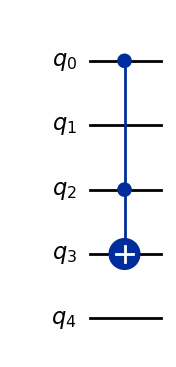

In [2]:
# Create a qubit with 5 qubits:
qc = QuantumCircuit(5)
# Apply the Toffoli gate:
qc.ccx(0,2,3)
qc.draw("mpl")

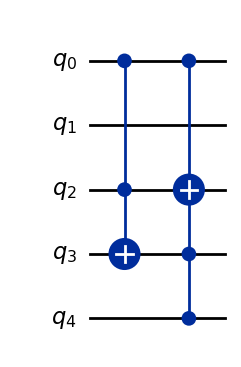

In [3]:
qc.mcx([0,3,4],2)
qc.draw("mpl")

### Using registers

In [4]:
qc.measure_all()
print("Quantum registers:", qc.qregs)
print("Classical registers:", qc.cregs)

Quantum registers: [QuantumRegister(5, 'q')]
Classical registers: [ClassicalRegister(5, 'meas')]


In [5]:
from qiskit import QuantumRegister, ClassicalRegister

qc.new_qreg = QuantumRegister(1, name = "new")
qc.new_creg = ClassicalRegister(10, name = "new_c")
qc.add_register(qc.new_qreg, qc.new_creg)

Quantum registers: [QuantumRegister(5, 'q'), QuantumRegister(1, 'new')]
Classical registers: [ClassicalRegister(5, 'meas'), ClassicalRegister(10, 'new_c')]


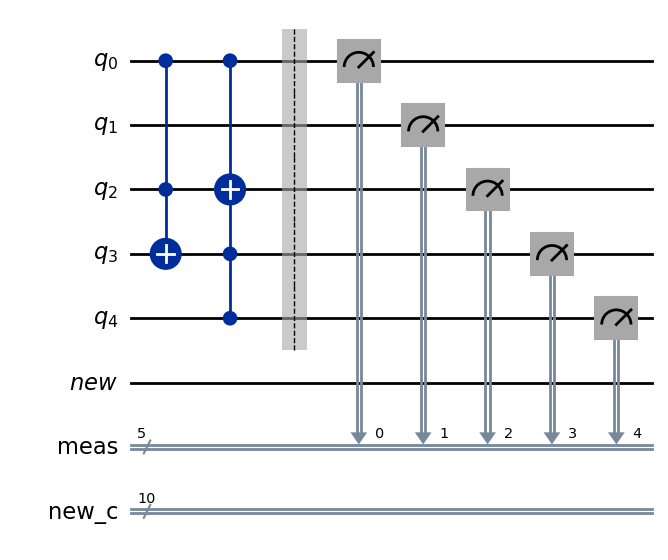

In [6]:
print("Quantum registers:", qc.qregs)
print("Classical registers:", qc.cregs)
qc.draw("mpl")

### How to verify the equivalence of circuits

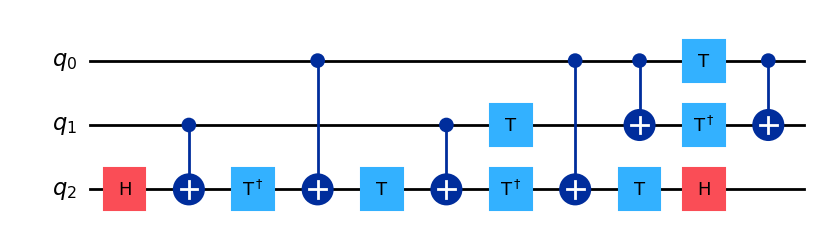

In [7]:
tof = QuantumCircuit(3)
tof.h(2)
tof.cx(1,2)
tof.tdg(2)
tof.cx(0,2)
tof.t(2)
tof.cx(1,2)
tof.tdg(2)
tof.cx(0,2)
tof.t(1)
tof.t(2)
tof.cx(0,1)
tof.h(2)
tof.t(0)
tof.tdg(1)
tof.cx(0,1)
tof.draw("mpl") # Draw it to check it!

In [8]:
from qiskit.quantum_info import Operator
real_tof = QuantumCircuit(3)
real_tof.ccx(0,1,2) # This circuit has the actual Toffoli gate.

# Check if the operators are equal:
print(Operator(tof) == Operator(real_tof))

True


## 10.2. Quantum teleportation

In [9]:
qt = QuantumCircuit(3)
qt.h(1)
qt.cx(1,2)
qt.cx(0,1)
qt.h(0)

In [10]:
qt.aux = ClassicalRegister(2, name = "aux")
qt.add_register(qt.aux)

qt.measure(0, qt.aux[0])
qt.measure(1, qt.aux[1])

In [11]:
# Apply X on qubit 2 if aux[1] == 1 
with qt.if_test((qt.cregs[0][1], 1)):
    qt.x(2)

# Apply Z on qubit 2 if aux[0] == 1
with qt.if_test((qt.cregs[0][0], 1)):
    qt.z(2)

In [12]:
qt.final = ClassicalRegister(1, name = "final")
qt.add_register(qt.final)
qt.measure(2,qt.final)

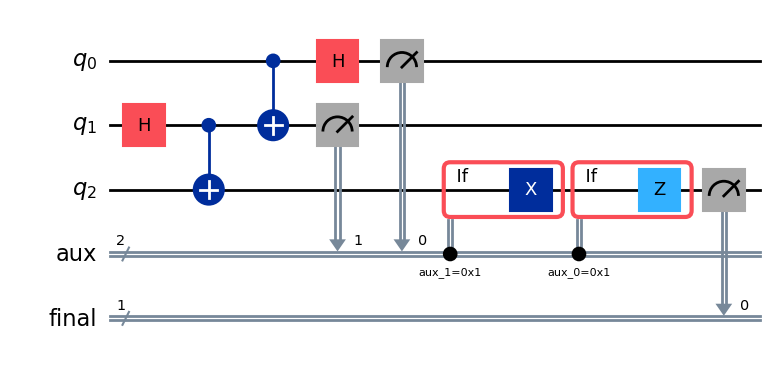

In [13]:
qt.draw("mpl")

In [14]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler

backend = AerSimulator(seed_simulator = 18620123)
sampler = Sampler(backend)

In [15]:
def quantum_teleportation(state_preparation):
    # Compose the state_preparation circuit with qt.
	# We use front = True for state_preparation to go before qt.
    circuit = qt.compose(state_preparation, front = True)
    # Get the results.
    job = sampler.run([circuit])
    return job.result()[0].data.final

In [16]:
result_0 = quantum_teleportation(QuantumCircuit(1))
print(result_0.get_counts())

{'0': 1024}


In [17]:
state_plus = QuantumCircuit(1)
state_plus.h(0)

result_plus = quantum_teleportation(state_plus)
print(result_plus.get_counts())

{'1': 513, '0': 511}


## 10.3 The Deutsch-Jozsa algorithm

### Let's build some oracles

In [18]:
def build_oracle(strings_one):
    # If the function is never 1, the oracle is the identity.
    # Hence, we return an empty circuit.
    if len(strings_one) == 0:
        return QuantumCircuit()
        
    # Number of bits that the function takes as input:
    n = len(strings_one[0])
    
    qc = QuantumCircuit(n+1)
    for x in strings_one:
        # Find the positions in the string x where the bit is 0.
        # For this, we find the list of indices i such that x[i]=='0'.
        bits_zero = []
        for i in range(len(x)):
            val = x[i]
            if val == '0':
                bits_zero.append(i)

        # Step 1 in our construction.
        for bit in bits_zero:
            qc.x(bit)

        # Step 2.
        qc.mcx(list(range(n)), n)
        
        # Step 3.
        for bit in bits_zero:
            qc.x(bit)

    return qc

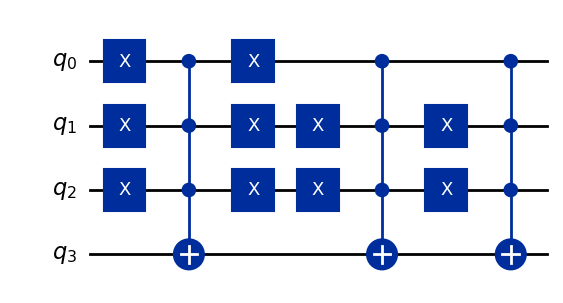

In [19]:
build_oracle(["000", "100", "111"]).draw("mpl")

In [20]:
def DJ(oracle):
    # Number of qubits in the circuit (same as the oracle).
    # If we are working with an n-bit function, nqubits = n + 1.
    nqubits = oracle.num_qubits 
    
    # Create a circuit with (nqubits) qubits and (nqubits-1) bits.
    # Remember we are only going to measure the first (nqubits-1) qubits!
    qc = QuantumCircuit(nqubits, nqubits - 1)

    # Initialize the bottom qubit to |1>.
    qc.x(nqubits - 1)
    
    for i in range(nqubits):
        qc.h(i)
    qc.barrier()
    qc = qc.compose(oracle)
    qc.barrier()
    for i in range(nqubits - 1):
        qc.h(i)
        qc.measure(i,i)
    return qc

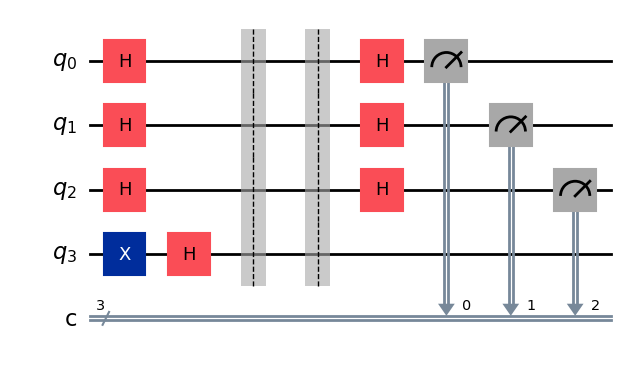

In [21]:
oracle = QuantumCircuit(4)
dj = DJ(oracle)
dj.draw("mpl")

In [22]:
job = sampler.run([dj], shots = 1)
result = job.result()[0].data.c
print(result.get_bitstrings())

['000']


In [23]:
# Oracle of a balanced function (takes the value 1 with four inputs):
oracle = build_oracle(["000", "101", "100", "110"])
# Prepare the D-J circuit:
dj = DJ(oracle)
# Run it!
job = sampler.run([dj], shots = 1)
result = job.result()[0].data.c
print(result.get_bitstrings())

['010']


## 10.4 The Bernstein-Vazirani algorithm

In [24]:
oracle = build_oracle(["001", "011", "100", "110"])
dj = DJ(oracle)
job = sampler.run([dj], shots = 1)
result = job.result()[0].data.c
print(result.get_bitstrings())

['101']
